# Python Project
### Adeline Casali
### August 24, 2023

### All libraries used loaded below

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

### All data loaded in below

In [8]:
cost_of_living_df = pd.read_csv('cost_of_living.csv')
salaries_df = pd.read_csv('ds_salaries.csv')
levels_salary_df = pd.read_csv('Levels_Fyi_Salary_Data.csv')
country_codes_df = pd.read_excel('country_codes.xlsx')

### Data Cleaning and Preparation

#### Separating country and city and joining country codes

In this part of the analysis, I prepared the data for further analysis by separating it into city and country and joining the country codes with both the cost_of_living_df and levels_salary_df. This will allow me to concatenate the two datasets and do a currency conversion in the future. 

In [9]:
# In cost_of_living_df, separate city into country and city
city = []
country = []
for city_info in cost_of_living_df['City']:
    city_info_split = city_info.split(', ')
    if len(city_info_split) == 3:
        city.append(f"{city_info_split[0]}, {city_info_split[1]}")
        country.append(city_info_split[2])
    else:
        city.append(city_info_split[0])
        country.append(city_info_split[1])
cost_of_living_df['City'] = city
cost_of_living_df['Country'] = country
print(cost_of_living_df[['City', 'Country']].head())

# Change United States to United States of America (the)
cost_of_living_df['Country'] = cost_of_living_df['Country'].replace('United States', 'United States of America (the)')

# Add country codes to cost_of_living_df
cost_of_living_df = cost_of_living_df.merge(country_codes_df, left_on='Country', right_on='Country', how='left')
print(cost_of_living_df.head())

# Aggregate by country code
agg_columns = ['Cost of Living Index', 'Rent Index', 'Cost of Living Plus Rent Index',
               'Groceries Index', 'Restaurant Price Index', 'Local Purchasing Power Index']
country_COL_df = cost_of_living_df.groupby('Country')[agg_columns].mean()
country_COL_df = country_COL_df.reset_index()
print(country_COL_df.head())

# Add , United States to locations in the US in levels_salary_df
levels_salary_df['location'] = levels_salary_df['location'].apply(lambda x: x + ", United States" if len(x.split(', ')) == 2 else x)
print(levels_salary_df['location'].head())

# Separate levels_salary_df location into City and Country
split_data = levels_salary_df['location'].str.rsplit(', ', n=1, expand=True)
levels_salary_df['City'] = split_data[0]
levels_salary_df['Country'] = split_data[1]
print(levels_salary_df[['City', 'Country']].head())

# Change United States to United States of America (the)
levels_salary_df['Country'] = levels_salary_df['Country'].replace('United States', 'United States of America (the)')

# Add country codes to levels_salary_df
levels_salary_df = levels_salary_df.merge(country_codes_df, on='Country', how='left')
print(levels_salary_df.head())

       City      Country
0  Hamilton      Bermuda
1    Zurich  Switzerland
2     Basel  Switzerland
3       Zug  Switzerland
4    Lugano  Switzerland
   Rank      City  Cost of Living Index  Rent Index  \
0   NaN  Hamilton                149.02       96.10   
1   NaN    Zurich                131.24       69.26   
2   NaN     Basel                130.93       49.38   
3   NaN       Zug                128.13       72.12   
4   NaN    Lugano                123.99       44.99   

   Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                          124.22           157.89                  155.22   
1                          102.19           136.14                  132.52   
2                           92.70           137.07                  130.95   
3                          101.87           132.61                  130.93   
4                           86.96           129.17                  119.80   

   Local Purchasing Power Index      Country Alpha

#### Merging salary data and adding in currency conversion

In this section, I created a function to fetch exchange rates (it was taking too long when I originally had it fetching for each conversion individually) and then another function to convert the currency using the exchange rates. I then merged the two salary dataframes and retained information such as company location, and used the company locations and currency from salaries_df to add in currencies for each location. From there I completed the currency conversion to USD. 

In [10]:
# Create functions to fetch exchange rates and convert currency
def fetch_exchange_rates():
    base_url = "https://api.exchangerate-api.com/v4/latest/USD"
    response = requests.get(base_url)
    data = response.json()
    rates = data.get('rates', {})
    return rates

def convert_currency(row, exchange_rates):
    salary_currency = row['salary_currency']
    if salary_currency == 'USD':
        return row['salary']
    elif salary_currency in exchange_rates:
        return row['salary'] * exchange_rates[salary_currency]
    else:
        return None
        
# Concat levels_salary_df to salaries_df
levels_salary_df.rename(columns={'totalyearlycompensation': 'salary'}, inplace=True)
levels_salary_df.rename(columns={'Alpha-2 code': 'company_location'}, inplace=True)
selected_salaries_df = salaries_df[['salary', 'company_location']]
selected_levels_salary_df = levels_salary_df[['salary', 'company_location']]
salaries_locations_df = pd.concat([selected_salaries_df, selected_levels_salary_df], axis=0, ignore_index=True)
print(salaries_locations_df.head())

# Add in salary currency
currency_salaries_df = salaries_df[['company_location', 'salary_currency']]
salaries_locations_df = salaries_locations_df.merge(currency_salaries_df, on='company_location', how='left')
print(salaries_locations_df.head())

# Convert all salaries to USD using comvert_currency
exchange_rates = fetch_exchange_rates()
salaries_locations_df['salary_in_usd'] = salaries_locations_df.apply(
    lambda row: convert_currency(row, exchange_rates),
    axis=1
)

print(salaries_locations_df.head())

   salary company_location
0   70000               DE
1  260000               JP
2   85000               GB
3   20000               HN
4  150000               US
   salary company_location salary_currency
0   70000               DE             EUR
1   70000               DE             EUR
2   70000               DE             EUR
3   70000               DE             EUR
4   70000               DE             EUR
   salary company_location salary_currency  salary_in_usd
0   70000               DE             EUR        64470.0
1   70000               DE             EUR        64470.0
2   70000               DE             EUR        64470.0
3   70000               DE             EUR        64470.0
4   70000               DE             EUR        64470.0


### Analysis

I calculated the average salary per country and used that to find the ratio of cost of living index to salary in USD to see where money would go the furthest. The results were Chile, Hungary, Japan, India, and Turkey. 

In [15]:
# Calculate avg salary in USD per country
average_salary_per_country = salaries_locations_df.groupby('company_location')['salary_in_usd'].mean()
average_salary_per_country_df = average_salary_per_country.reset_index()
average_salary_per_country_df.rename(columns={'company_location': 'Country', 'salary_in_usd': 'Average Salary USD'}, inplace=True)
print(average_salary_per_country_df.head())

# Join to cost_of_living
COL_salaries_df = cost_of_living_df.merge(average_salary_per_country_df, left_on='Alpha-2 code', right_on='Country', how='inner')
print(COL_salaries_df.head())

# Calculate the ratio of Cost of Living Index to Average Salary USD
COL_salaries_df['COL_to_Salary_Ratio'] = COL_salaries_df['Cost of Living Index'] / COL_salaries_df['Average Salary USD']
print(COL_salaries_df.head())

# Assign rank based on countries with the best COL ratio
COL_salaries_df['Rank'] = COL_salaries_df['COL_to_Salary_Ratio'].rank(ascending=True)
print(COL_salaries_df.head())

# Print the top 5 ranked based on COL to salary (USD) ratio
top_5_ranked_cities = COL_salaries_df.nsmallest(5, 'Rank')
print(top_5_ranked_cities)

# Aggregate by country and print the top 5 countries based on COL to salary (USD) ratio
COL_salaries_countries_df = COL_salaries_df.drop(columns=['Rank'])
country_mean_ratios = COL_salaries_countries_df.groupby('Country_y')['COL_to_Salary_Ratio'].mean()
country_mean_ratios = country_mean_ratios.dropna()
country_names_dict = COL_salaries_countries_df.set_index('Country_y')['Country_x'].to_dict()
country_mean_ratios_with_names = country_mean_ratios.index.map(country_names_dict)
country_mean_ratios_with_names_series = pd.Series(country_mean_ratios.index.values, index=country_mean_ratios_with_names)
country_mean_ratios_with_names_series = country_mean_ratios_with_names_series.to_frame(name='Country_x')
country_mean_ratios_with_names_series['COL_to_Salary_Ratio'] = country_mean_ratios.values
country_mean_ratios_with_names_series = country_mean_ratios_with_names_series.sort_values(by='COL_to_Salary_Ratio', ascending=True)
country_mean_ratios_with_names_series['Rank'] = country_mean_ratios_with_names_series['COL_to_Salary_Ratio'].rank(ascending=True)
top_5_ranked_countries = country_mean_ratios_with_names_series.head(5)
print(top_5_ranked_countries)

  Country  Average Salary USD
0      AE        1.000000e+05
1      AM                 NaN
2      AR                 NaN
3      AS        1.102844e+08
4      AT        8.355982e+04
   Rank      City  Cost of Living Index  Rent Index  \
0   NaN    Zurich                131.24       69.26   
1   NaN     Basel                130.93       49.38   
2   NaN       Zug                128.13       72.12   
3   NaN    Lugano                123.99       44.99   
4   NaN  Lausanne                122.03       59.55   

   Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                          102.19           136.14                  132.52   
1                           92.70           137.07                  130.95   
2                          101.87           132.61                  130.93   
3                           86.96           129.17                  119.80   
4                           92.74           122.56                  127.01   

   Local Purchasing 

### Visualization

#### Top 5 cities and countries based on cost of living (COL) to salary ratio

Here I've visualized the top 5 cities and countries with the lowest cost of living to salary ratio. The top city was Santiago, in Chile, and the next 4 cities were all based out of Hungary. 

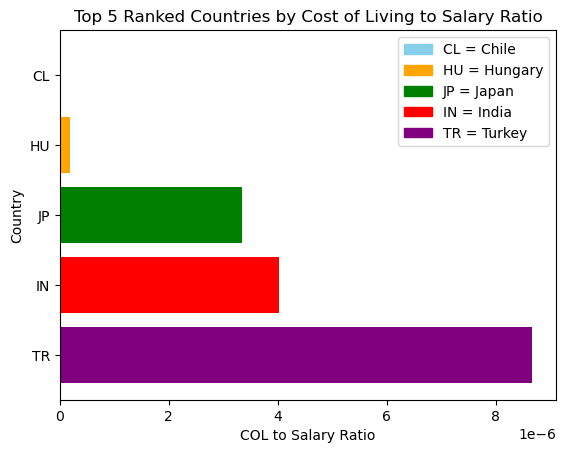

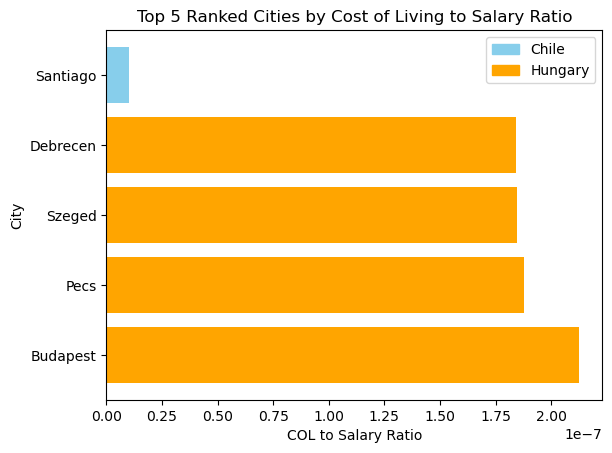

In [12]:
# Create a bar plot with the top 5 countries and their COL ratio
top_5_ranked_countries = top_5_ranked_countries.sort_values(by='COL_to_Salary_Ratio', ascending=True)
country_colors = {'CL': 'skyblue', 'HU': 'orange', 'JP': 'green', 'IN': 'red', 'TR': 'purple'}
plt.barh(top_5_ranked_countries['Country_x'], top_5_ranked_countries['COL_to_Salary_Ratio'], color=[country_colors.get(code, 'gray') for code in top_5_ranked_countries['Country_x']])
plt.xlabel('COL to Salary Ratio')
plt.ylabel('Country')
plt.title('Top 5 Ranked Countries by Cost of Living to Salary Ratio')
plt.gca().invert_yaxis()
custom_legend_labels = {'CL': 'Chile', 'HU': 'Hungary', 'JP': 'Japan', 'IN': 'India', 'TR': 'Turkey'}
handles = [plt.Rectangle((0,0),1,1, color=country_colors.get(code, 'gray'), label=f'{code} = {name}') for code, name in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

# Create a bar plot with the top 5 cities and their COL ratio
city_colors = {'Santiago': 'skyblue', 'Debrecen': 'orange', 'Szeged': 'orange', 'Pecs': 'orange', 'Budapest': 'orange'}
top_5_ranked_cities = top_5_ranked_cities.sort_values(by='COL_to_Salary_Ratio', ascending=True)
plt.barh(top_5_ranked_cities['City'], top_5_ranked_cities['COL_to_Salary_Ratio'], color=[city_colors.get(city, 'gray') for city in top_5_ranked_cities['City']])
plt.xlabel('COL to Salary Ratio')
plt.ylabel('City')
plt.title('Top 5 Ranked Cities by Cost of Living to Salary Ratio')
plt.gca().invert_yaxis()
custom_legend_labels = {'Santiago': 'Chile', 'Debrecen': 'Hungary'}
handles = [plt.Rectangle((0, 0), 1, 1, color=city_colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

#### Top 5 cities per index

I then looked at each of the indexes and visualized the cities with the best indexes overall and based on rent, groceries, restaurants, and purchasing power. Most cities are based out of India or Pakistan, but the cities with the highest purchasing power are all based out of the US. 

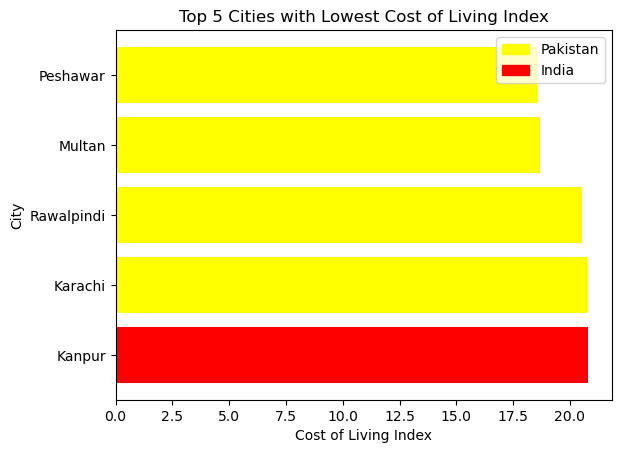

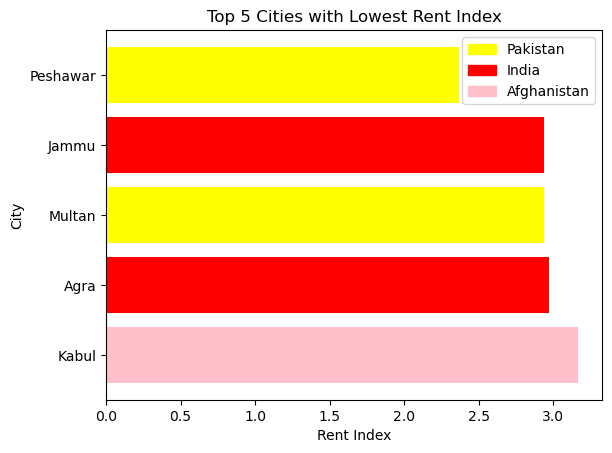

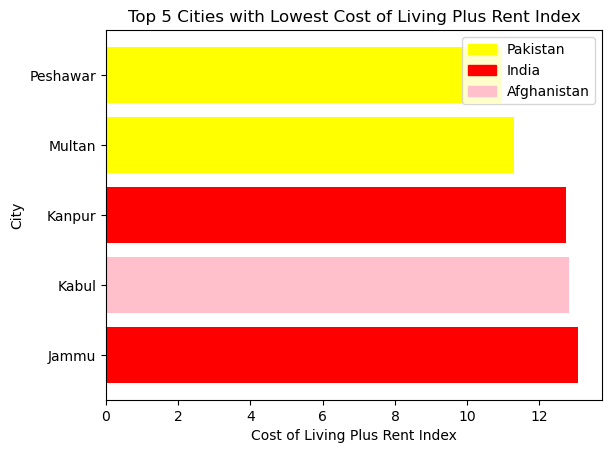

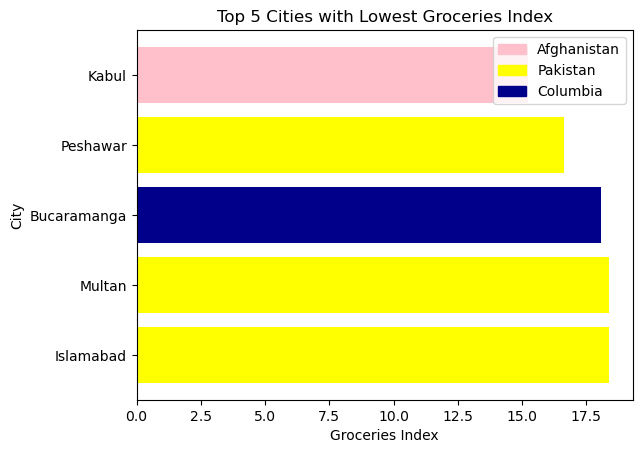

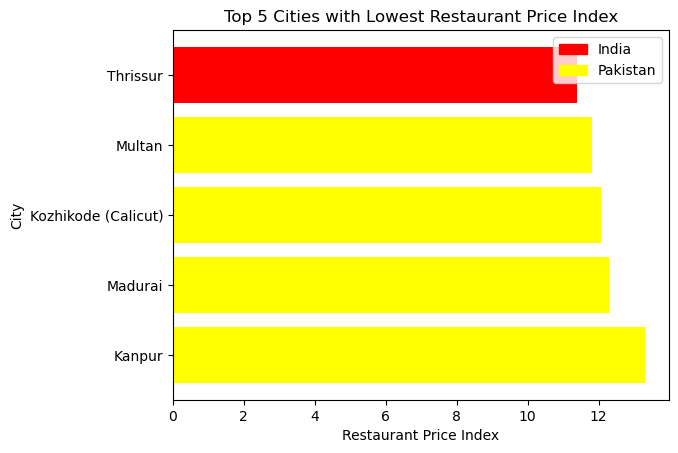

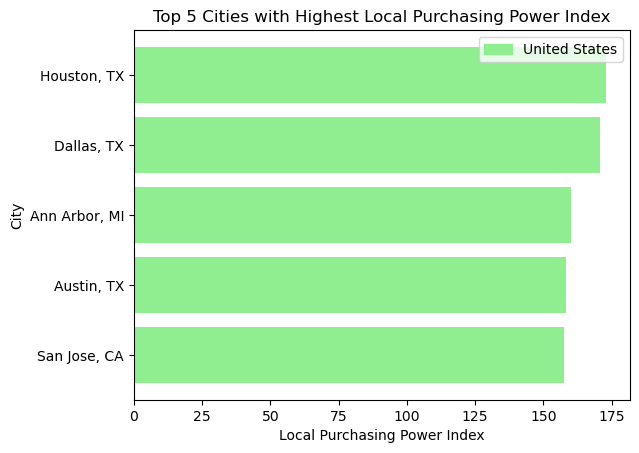

In [13]:
# Create a bar plot with the top 5 cities based on overall COL Index
top_5_cities_col = cost_of_living_df.sort_values(by='Cost of Living Index', ascending=True).head(5)
colors = {'Peshawar': 'yellow', 'Multan': 'yellow', 'Rawalpindi': 'yellow', 'Karachi': 'yellow', 'Kanpur': 'red'}
plt.barh(top_5_cities_col['City'], top_5_cities_col['Cost of Living Index'], color=colors.values())
plt.xlabel('Cost of Living Index')
plt.ylabel('City')
plt.title('Top 5 Cities with Lowest Cost of Living Index')
plt.gca().invert_yaxis()
custom_legend_labels = {'Peshawar': 'Pakistan', 'Kanpur': 'India'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

# Create a bar plot with the top 5 cities based on Rent Index
top_5_cities_rent = cost_of_living_df.sort_values(by='Rent Index', ascending=True).head(5)
colors = {'Peshawar': 'yellow', 'Jammu': 'red', 'Multan': 'yellow', 'Agra': 'red', 'Kabul': 'pink'}
plt.barh(top_5_cities_rent['City'], top_5_cities_rent['Rent Index'], color=colors.values())
plt.xlabel('Rent Index')
plt.ylabel('City')
plt.title('Top 5 Cities with Lowest Rent Index')
plt.gca().invert_yaxis()
custom_legend_labels = {'Peshawar': 'Pakistan', 'Jammu': 'India', 'Kabul': 'Afghanistan'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

# Create a bar plot with the top 5 cities based on Living plus Rent Index
top_5_cities_col_rent = cost_of_living_df.sort_values(by='Cost of Living Plus Rent Index', ascending=True).head(5)
colors = {'Peshawar': 'yellow', 'Multan': 'yellow', 'Kanpur': 'red', 'Kabul': 'pink', 'Jammu': 'red'}
plt.barh(top_5_cities_col_rent['City'], top_5_cities_col_rent['Cost of Living Plus Rent Index'], color=colors.values())
plt.xlabel('Cost of Living Plus Rent Index')
plt.ylabel('City')
plt.title('Top 5 Cities with Lowest Cost of Living Plus Rent Index')
plt.gca().invert_yaxis()
custom_legend_labels = {'Peshawar': 'Pakistan', 'Jammu': 'India', 'Kabul': 'Afghanistan'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

# Create a bar plot with the top 5 cities based on Groceries Index
top_5_cities_groceries = cost_of_living_df.sort_values(by='Groceries Index', ascending=True).head(5)
colors = {'Kabul': 'pink', 'Peshawar': 'yellow', 'Bucaramanga': 'darkblue', 'Multan': 'yellow', 'Islamabad': 'yellow'}
plt.barh(top_5_cities_groceries['City'], top_5_cities_groceries['Groceries Index'], color=colors.values())
plt.xlabel('Groceries Index')
plt.ylabel('City')
plt.title('Top 5 Cities with Lowest Groceries Index')
plt.gca().invert_yaxis()
custom_legend_labels = {'Kabul': 'Afghanistan', 'Peshawar': 'Pakistan', 'Bucaramanga': 'Columbia'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

# Create a bar plot with the top 5 cities based on Restaurant Price Index
top_5_cities_restaurant = cost_of_living_df.sort_values(by='Restaurant Price Index', ascending=True).head(5)
colors = {'Thrissur': 'red', 'Multan': 'yellow', 'Kozhikode (Calicut)': 'yellow', 'Madurai': 'yellow', 'Kanpur': 'yellow'}
plt.barh(top_5_cities_restaurant['City'], top_5_cities_restaurant['Restaurant Price Index'], color=colors.values())
plt.xlabel('Restaurant Price Index')
plt.ylabel('City')
plt.title('Top 5 Cities with Lowest Restaurant Price Index')
plt.gca().invert_yaxis()
custom_legend_labels = {'Thrissur': 'India', 'Multan': 'Pakistan'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

# Create a bar plot with the top 5 cities based on Local Purchasing Power Index
top_5_cities_purchasing_power = cost_of_living_df.sort_values(by='Local Purchasing Power Index', ascending=False).head(5)
colors = {'Houston, TX': 'lightgreen'}
plt.barh(top_5_cities_purchasing_power['City'], top_5_cities_purchasing_power['Local Purchasing Power Index'], color=colors.values())
plt.xlabel('Local Purchasing Power Index')
plt.ylabel('City')
plt.title('Top 5 Cities with Highest Local Purchasing Power Index')
plt.gca().invert_yaxis()
custom_legend_labels = {'Houston, TX': 'United States'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(city, 'gray'), label=label) for city, label in custom_legend_labels.items()]
plt.legend(handles=handles)
plt.show()

#### Top 5 countries per index

Finally, I looked at the countries with the best index values. Many of the top countries are middle eastern countries such as Pakistan and Afghanistan, but purchasing power was the highest in more western countries such as Switzerland, the US, and Germany. Overall, indexes and ratios are just the tip of the iceberg when it comes to deciding on new places to live, but it was interesting to explore the data nonetheless! 

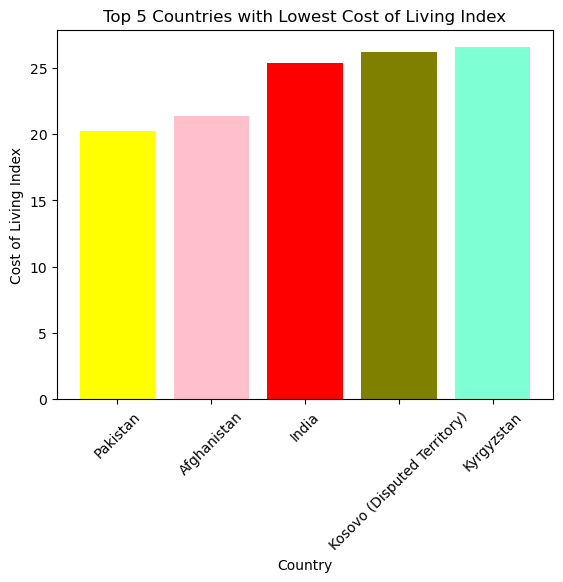

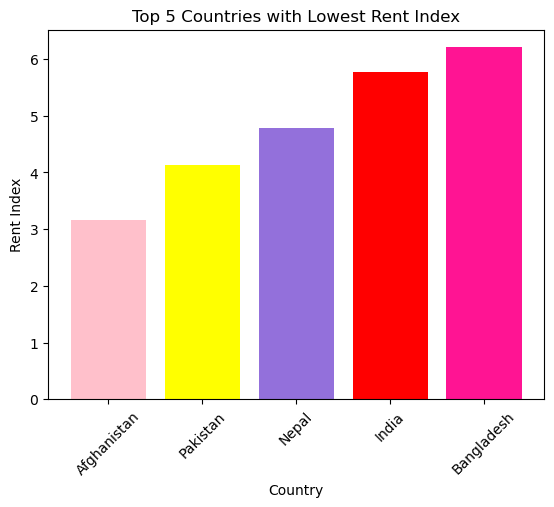

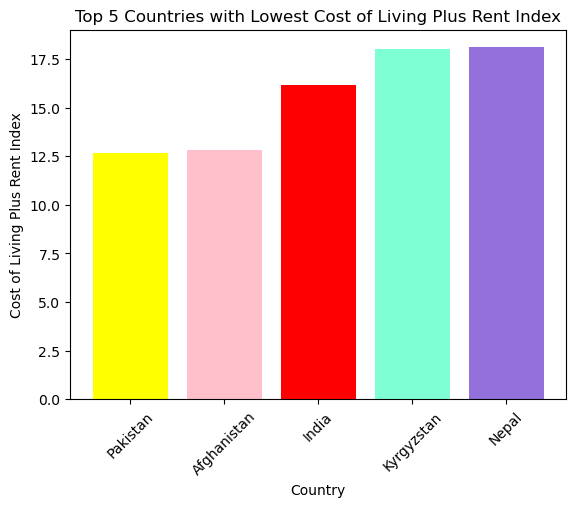

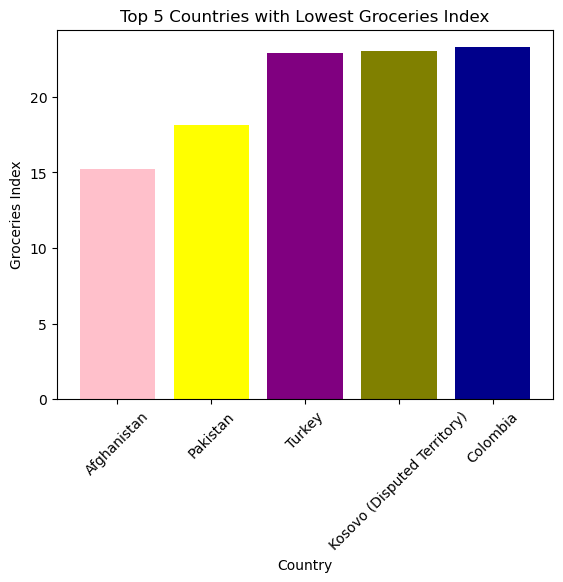

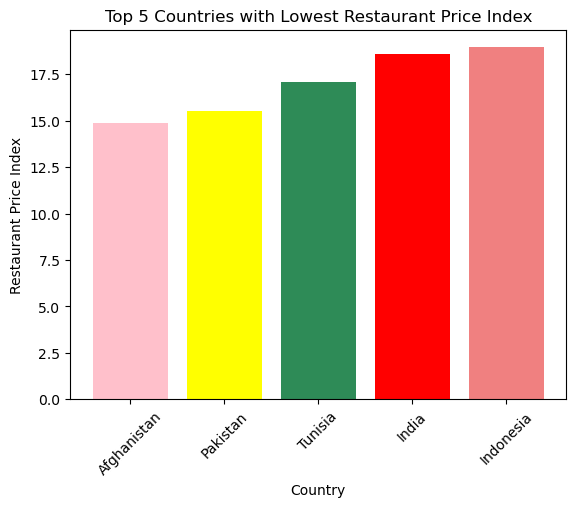

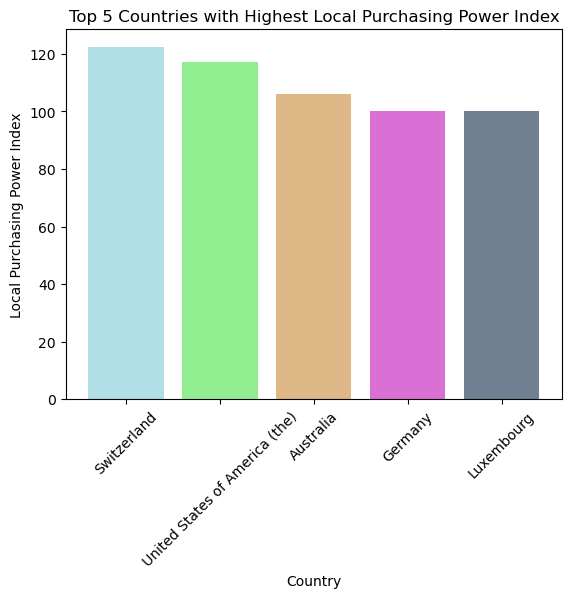

In [16]:
# Create a bar plot with the top 5 countries based on overall COL Index
top_5_countries_col = country_COL_df.sort_values(by='Cost of Living Index', ascending=True).head(5)
colors = {'Pakistan': 'yellow', 'Afghanistan': 'pink', 'India': 'red', 'Kosovo (Disputed Territory)': 'olive', 'Kyrgyztan': 'aquamarine'}
plt.bar(top_5_countries_col['Country'], top_5_countries_col['Cost of Living Index'], color=colors.values())
plt.xlabel('Country')
plt.ylabel('Cost of Living Index')
plt.title('Top 5 Countries with Lowest Cost of Living Index')
plt.xticks(rotation=45)
plt.show()

# Create a bar plot with the top 5 countries based on Rent Index
top_5_countries_rent = country_COL_df.sort_values(by='Rent Index', ascending=True).head(5)
colors = {'Afghanistan': 'pink', 'Pakistan': 'yellow', 'Nepal': 'mediumpurple', 'India': 'red', 'Bangladesh': 'deeppink'}
plt.bar(top_5_countries_rent['Country'], top_5_countries_rent['Rent Index'], color=colors.values())
plt.xlabel('Country')
plt.ylabel('Rent Index')
plt.title('Top 5 Countries with Lowest Rent Index')
plt.xticks(rotation=45) 
plt.show()

# Create a bar plot with the top 5 countries based on Living plus Rent Index
top_5_countries_living_rent = country_COL_df.sort_values(by='Cost of Living Plus Rent Index', ascending=True).head(5)
colors = {'Pakistan': 'yellow', 'Afghanistan': 'pink', 'India': 'red', 'Kyrgyzstan': 'aquamarine', 'Nepal': 'mediumpurple'}
plt.bar(top_5_countries_living_rent['Country'], top_5_countries_living_rent['Cost of Living Plus Rent Index'], color=colors.values())
plt.xlabel('Country')
plt.ylabel('Cost of Living Plus Rent Index')
plt.title('Top 5 Countries with Lowest Cost of Living Plus Rent Index')
plt.xticks(rotation=45)  
plt.show()

# Create a bar plot with the top 5 countries based on Groceries Index
top_5_countries_groceries = country_COL_df.sort_values(by='Groceries Index', ascending=True).head(5)
colors = {'Afghanistan': 'pink', 'Pakistan': 'yellow', 'Turkey': 'purple', 'Kosovo (Disputed Territory)': 'olive', 'Columbia': 'darkblue'}
plt.bar(top_5_countries_groceries['Country'], top_5_countries_groceries['Groceries Index'], color=colors.values())
plt.xlabel('Country')
plt.ylabel('Groceries Index')
plt.title('Top 5 Countries with Lowest Groceries Index')
plt.xticks(rotation=45) 
plt.show()

# Create a bar plot with the top 5 countries based on Restaurant Price Index
top_5_countries_restaurant = country_COL_df.sort_values(by='Restaurant Price Index', ascending=True).head(5)
colors = {'Afghanistan': 'pink', 'Pakistan': 'yellow', 'Tunisia': 'seagreen', 'India': 'red', 'Indonesia': 'lightcoral'}
plt.bar(top_5_countries_restaurant['Country'], top_5_countries_restaurant['Restaurant Price Index'], color=colors.values())
plt.xlabel('Country')
plt.ylabel('Restaurant Price Index')
plt.title('Top 5 Countries with Lowest Restaurant Price Index')
plt.xticks(rotation=45)  
plt.show()

# Create a bar plot with the top 5 countries based on Local Purchasing Power Index
top_5_countries_purchasing_power = country_COL_df.sort_values(by='Local Purchasing Power Index', ascending=False).head(5)
colors = {'Switzerland': 'powderblue', 'United States of America (the)': 'lightgreen', 'Australia': 'burlywood', 'Germany': 'orchid', 'Luxembourg': 'slategrey'}
plt.bar(top_5_countries_purchasing_power['Country'], top_5_countries_purchasing_power['Local Purchasing Power Index'], color=colors.values())
plt.xlabel('Country')
plt.ylabel('Local Purchasing Power Index')
plt.title('Top 5 Countries with Highest Local Purchasing Power Index')
plt.xticks(rotation=45) 
plt.show()